In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torch_geometric.loader import DataLoader as TGDataLoader
from gadff.horm.training_module import PotentialModule, compute_extra_props
from gadff.horm.ff_lmdb import LmdbDataset

# Set up torch
torch.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


/home/andreasburger/miniforge3/envs/gad/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = torc

In [2]:
# Load model
checkpoint_path = "ckpt/eqv2.ckpt"
lmdb_path = "data/sample_100.lmdb"

# Load checkpoint to get model info
ckpt = torch.load(checkpoint_path, map_location="cpu")
model_name = ckpt["hyper_parameters"]["model_config"]["name"]
print(f"Model name: {model_name}")

# Load the potential model
pm = PotentialModule.load_from_checkpoint(
    checkpoint_path,
    strict=False,
).potential.to(device)

pm.eval()
print("Model loaded successfully")

/tmp/ipykernel_1202653/1516365771.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location='cpu')


Model name: EquiformerV2
Model loaded successfully


In [3]:
# Load dataset and get one sample
dataset = LmdbDataset(lmdb_path)
dataloader = TGDataLoader(dataset, batch_size=1, shuffle=False)

# Get the first sample
sample = next(iter(dataloader))
sample = sample.to(device)
sample = compute_extra_props(sample)

print(f"Sample keys: {list(sample.keys())}")
print(f"Sample pos: {sample.pos}")
print(f"Sample info:")
print(f"  Number of atoms: {sample.pos.shape[0]}")
print(f"  Positions shape: {sample.pos.shape}")

# Check what we have for atomic types
print(f"  Atomic numbers (z): {sample.z.cpu().numpy()}")

Sample keys: ['pos', 'charges', 'hessian', 'batch', 'forces', 'natoms', 'one_hot', 'ptr', 'rxn', 'energy', 'ae']
Sample pos: tensor([[ 0.8701, -2.6155,  0.3699],
        [ 0.5615, -1.4847,  0.0497],
        [-0.8733, -1.0286, -0.1719],
        [-1.1581,  0.4236,  0.2469],
        [-0.1632,  1.3564, -0.4523],
        [ 1.2015,  0.8626, -0.0653],
        [ 1.5598, -0.4181,  0.0090],
        [-1.0224, -1.1251, -1.2550],
        [-1.5414, -1.7366,  0.3199],
        [-2.1971,  0.6935,  0.0267],
        [-1.0259,  0.5440,  1.3300],
        [-0.3791,  1.3892, -1.5332],
        [-0.2397,  2.3917, -0.1227],
        [ 1.7688,  1.3338,  0.7271],
        [ 2.5635, -0.6623,  0.3298]], device='cuda:0')
Sample info:
  Number of atoms: 15
  Positions shape: torch.Size([15, 3])
  Charges: [8 6 6 6 6 6 6 1 1 1 1 1 1 1 1]
  One-hot shape: torch.Size([15, 5])
  Inferred atomic numbers: [4 2 2 2 2 2 2 1 1 1 1 1 1 1 1]


In [4]:
# Predict forces
sample.pos.requires_grad_()
sample = compute_extra_props(sample)

# Forward pass to get energy and forces
with torch.set_grad_enabled(True):
    if model_name == "LEFTNet":
        energy, predicted_forces = pm.forward_autograd(sample)
    else:
        energy, predicted_forces = pm.forward(sample)

print(f"Energy: {energy.item():.6f}")
print(f"Predicted forces shape: {predicted_forces.shape}")
print(f"Max force magnitude: {torch.norm(predicted_forces, dim=1).max().item():.6f}")

# Convert to numpy for plotting
positions = sample.pos.detach().cpu().numpy()
forces = predicted_forces.detach().cpu().numpy()

# Get atomic numbers - this dataset uses different format
atomic_numbers = sample.z.cpu().numpy()

print(f"Atomic numbers: {atomic_numbers}")

Energy: -2.916304
Predicted forces shape: torch.Size([15, 3])
Max force magnitude: 2.157043
Atomic numbers: [8 6 6 6 6 6 6 1 1 1 1 1 1 1 1]


In [5]:
# Define atomic colors for common elements
element_colors = {
    1: "white",  # H
    6: "black",  # C
    7: "blue",  # N
    8: "red",  # O
    9: "green",  # F
    15: "orange",  # P
    16: "yellow",  # S
    17: "green",  # Cl
}

# Define atomic radii for visualization
element_radii = {
    1: 0.3,  # H
    6: 0.7,  # C
    7: 0.65,  # N
    8: 0.6,  # O
    9: 0.5,  # F
    15: 1.0,  # P
    16: 1.0,  # S
    17: 1.0,  # Cl
}


def get_element_color(atomic_num):
    return element_colors.get(atomic_num, "gray")


def get_element_radius(atomic_num):
    return element_radii.get(atomic_num, 0.5)

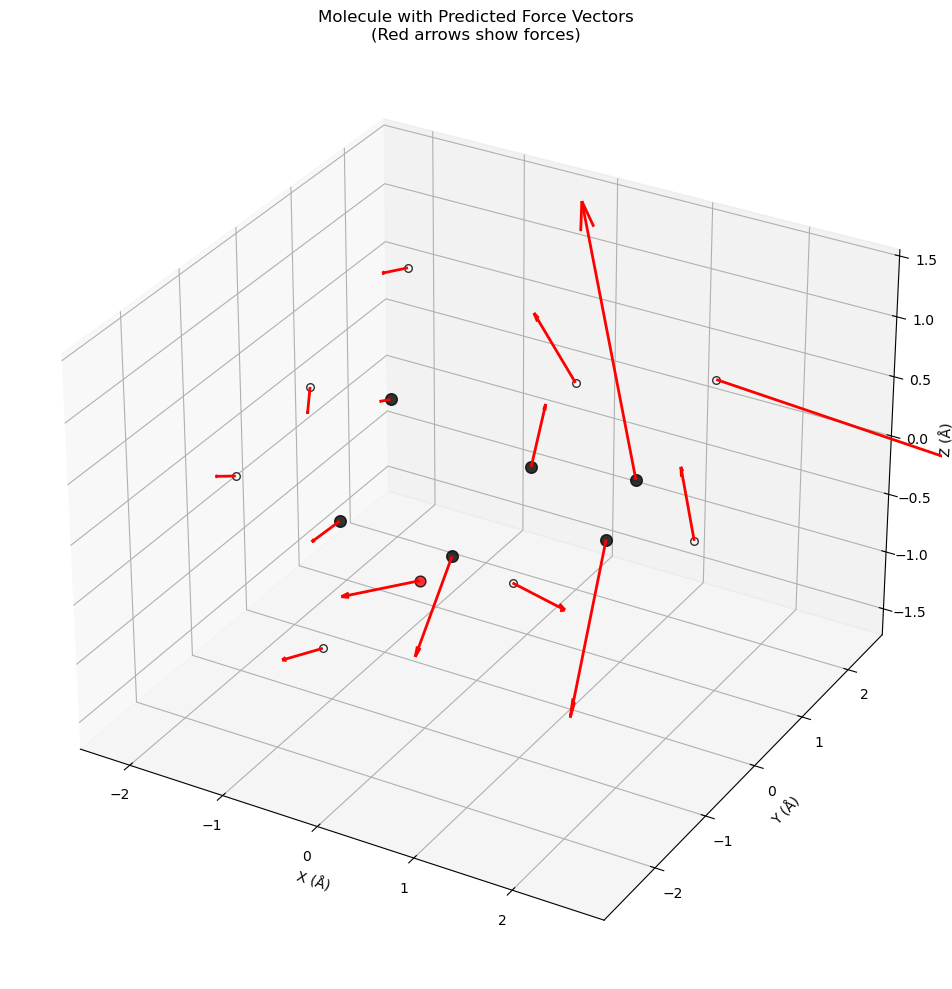

In [6]:
# Create 3D visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d")

# Plot atoms
for i, (pos, z) in enumerate(zip(positions, atomic_numbers)):
    color = get_element_color(z)
    radius = get_element_radius(z)

    ax.scatter(
        pos[0], pos[1], pos[2], c=color, s=radius * 100, alpha=0.8, edgecolors="black"
    )

# Plot force vectors
scale_factor = 2.0  # Adjust this to scale force vectors for visibility
for i, (pos, force) in enumerate(zip(positions, forces)):
    # Only plot forces with significant magnitude
    force_mag = np.linalg.norm(force)
    if force_mag > 0.01:  # Threshold to avoid plotting tiny forces
        ax.quiver(
            pos[0],
            pos[1],
            pos[2],
            force[0] * scale_factor,
            force[1] * scale_factor,
            force[2] * scale_factor,
            color="red",
            arrow_length_ratio=0.1,
            linewidth=2,
        )

# Set labels and title
ax.set_xlabel("X (Å)")
ax.set_ylabel("Y (Å)")
ax.set_zlabel("Z (Å)")
ax.set_title("Molecule with Predicted Force Vectors\n(Red arrows show forces)")

# Make the plot look better
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# plot with bonds
# use a library like rdkit to infer bonds


In [8]:
# Print force statistics
force_magnitudes = np.linalg.norm(forces, axis=1)

print("Force Statistics:")
print(f"Mean force magnitude: {np.mean(force_magnitudes):.6f}")
print(f"Max force magnitude: {np.max(force_magnitudes):.6f}")
print(f"Min force magnitude: {np.min(force_magnitudes):.6f}")
print(f"Std force magnitude: {np.std(force_magnitudes):.6f}")

print("\nAtom-wise force magnitudes:")
element_symbols = {1: "H", 6: "C", 7: "N", 8: "O", 9: "F", 15: "P", 16: "S", 17: "Cl"}
for i, (z, mag) in enumerate(zip(atomic_numbers, force_magnitudes)):
    symbol = element_symbols.get(z, f"Z{z}")
    print(f"Atom {i} ({symbol}, Z={z}): {mag:.6f}")

Force Statistics:
Mean force magnitude: 0.492445
Max force magnitude: 2.157043
Min force magnitude: 0.059750
Std force magnitude: 0.527225

Atom-wise force magnitudes:
Atom 0 (O, Z=8): 0.351623
Atom 1 (C, Z=6): 0.415783
Atom 2 (C, Z=6): 0.158420
Atom 3 (C, Z=6): 0.059750
Atom 4 (C, Z=6): 0.258566
Atom 5 (C, Z=6): 1.189813
Atom 6 (C, Z=6): 0.737829
Atom 7 (H, Z=1): 0.256762
Atom 8 (H, Z=1): 0.112653
Atom 9 (H, Z=1): 0.108076
Atom 10 (H, Z=1): 0.156907
Atom 11 (H, Z=1): 0.550461
Atom 12 (H, Z=1): 0.397002
Atom 13 (H, Z=1): 2.157043
Atom 14 (H, Z=1): 0.475985



Comparison with ground truth:
Mean absolute error: 0.005521
Max absolute error: 0.025119


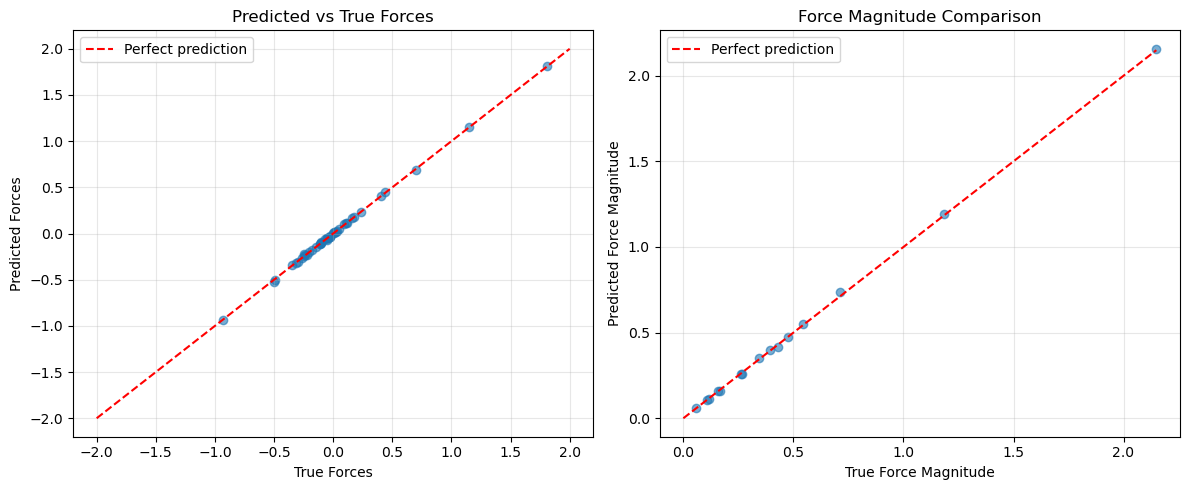

In [9]:
# Optional: Compare with ground truth forces if available
if hasattr(sample, "forces") and sample.forces is not None:
    true_forces = sample.forces.cpu().numpy()

    print("\nComparison with ground truth:")
    force_error = np.abs(forces - true_forces)
    print(f"Mean absolute error: {np.mean(force_error):.6f}")
    print(f"Max absolute error: {np.max(force_error):.6f}")

    # Plot comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Predicted vs true forces scatter plot
    ax1.scatter(true_forces.flatten(), forces.flatten(), alpha=0.6)
    ax1.plot([-2, 2], [-2, 2], "r--", label="Perfect prediction")
    ax1.set_xlabel("True Forces")
    ax1.set_ylabel("Predicted Forces")
    ax1.set_title("Predicted vs True Forces")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Force magnitude comparison
    true_mags = np.linalg.norm(true_forces, axis=1)
    pred_mags = np.linalg.norm(forces, axis=1)

    ax2.scatter(true_mags, pred_mags, alpha=0.6)
    ax2.plot(
        [0, np.max(true_mags)],
        [0, np.max(true_mags)],
        "r--",
        label="Perfect prediction",
    )
    ax2.set_xlabel("True Force Magnitude")
    ax2.set_ylabel("Predicted Force Magnitude")
    ax2.set_title("Force Magnitude Comparison")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("\nNo ground truth forces available for comparison.")

In [10]:
from predict_equiformer import get_smallest_eigenvalues_and_vectors, compute_hessian

# Plot the Hessian eigenvector with the smallest eigenvalue
print("\n" + "=" * 50)
print("Hessian Eigenvector Analysis")
print("=" * 50)


# Predict forces
sample.pos.requires_grad_()
sample = compute_extra_props(sample)

# Forward pass to get energy and forces
with torch.set_grad_enabled(True):
    if model_name == "LEFTNet":
        energy, predicted_forces = pm.forward_autograd(sample)
    else:
        energy, predicted_forces = pm.forward(sample)

hessian = compute_hessian(sample.pos, energy, predicted_forces)

# Get the smallest eigenvalue and corresponding eigenvector
smallest_eigenvals, smallest_eigenvecs = get_smallest_eigenvalues_and_vectors(
    hessian, n_smallest=1
)

# Extract the eigenvector (flattened coordinates)
eigenvector = smallest_eigenvecs[:, 0].cpu().numpy()  # Shape: [n_atoms*3]
eigenvalue = smallest_eigenvals[0].item()

print(f"Smallest eigenvalue: {eigenvalue:.6f}")
print(f"Eigenvector shape: {eigenvector.shape}")

# Reshape eigenvector to [n_atoms, 3] for visualization
eigenvector_reshaped = eigenvector.reshape(-1, 3)  # Shape: [n_atoms, 3]

coords = sample.pos.detach().cpu().numpy()
n_atoms = coords.shape[0]

# Create 3D plot for the eigenvector
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot atoms
scatter = ax.scatter(
    coords[:, 0],
    coords[:, 1],
    coords[:, 2],
    c=atomic_numbers,
    s=100,
    cmap="viridis",
    alpha=0.7,
)

# Plot eigenvector arrows (scaled for visibility)
scale_factor = 2.0  # Adjust this to make arrows more/less visible
eigenvector_scaled = eigenvector_reshaped * scale_factor

for i in range(n_atoms):
    start = coords[i]
    end = start + eigenvector_scaled[i]

    # Plot arrow
    ax.quiver(
        start[0],
        start[1],
        start[2],
        eigenvector_scaled[i, 0],
        eigenvector_scaled[i, 1],
        eigenvector_scaled[i, 2],
        color="red",
        alpha=0.8,
        length=1.0,
        arrow_length_ratio=0.3,
    )

# Add colorbar for atomic numbers
cbar = plt.colorbar(scatter)
cbar.set_label("Atomic Number")

ax.set_xlabel("X (Å)")
ax.set_ylabel("Y (Å)")
ax.set_zlabel("Z (Å)")
ax.set_title(
    f"Hessian Eigenvector (λ = {eigenvalue:.6f})\nRed arrows show displacement direction"
)

# Set equal aspect ratio
ax.set_box_aspect([1, 1, 1])

plt.tight_layout()
plt.show()

# Print eigenvector statistics
print(f"\nEigenvector statistics:")
print(f"Mean magnitude: {np.mean(np.linalg.norm(eigenvector_reshaped, axis=1)):.6f}")
print(f"Max magnitude: {np.max(np.linalg.norm(eigenvector_reshaped, axis=1)):.6f}")
print(f"Min magnitude: {np.min(np.linalg.norm(eigenvector_reshaped, axis=1)):.6f}")

# Optional: Show which atoms have the largest displacements
magnitudes = np.linalg.norm(eigenvector_reshaped, axis=1)
top_atoms = np.argsort(magnitudes)[-5:]  # Top 5 atoms by displacement magnitude

print(f"\nTop 5 atoms by eigenvector magnitude:")
for i, atom_idx in enumerate(reversed(top_atoms)):
    mag = magnitudes[atom_idx]
    z = atomic_numbers[atom_idx]
    symbol = element_symbols.get(z, f"Z{z}")
    print(f"  {i + 1}. Atom {atom_idx} ({symbol}): {mag:.6f}")

ModuleNotFoundError: No module named 'predict_equiformer'